#Classification on UTKFace Dataset
###Checkpoints are got from training script (included in submitted folder)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 132.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00


In [ ]:
from transformers import ViTModel

In [ ]:
# Geting pretrained ViT config
checkpoint_path = 'facebook/vit-mae-base'

##Preparing UTKFace Dataset

In [ ]:
from datasets import load_dataset

In [ ]:
# loading UTKFace from HuggingFace https://huggingface.co/datasets/nlphuji/utk_faces
dataset = load_dataset('nlphuji/utk_faces')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset utk_faces downloaded and prepared to /root/.cache/huggingface/datasets/nlphuji___utk_faces/TEST/1.1.0/60b003bec8467d7b5164765354625a2ef654d29e2a1f6595a54cf8fbbead96b9. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

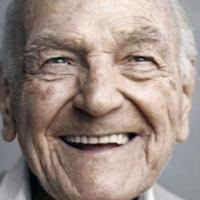

In [ ]:
dataset['test']['image'][1]

In [ ]:
label_age = dataset['test']['age']
label_gender = dataset['test']['gender']

In [ ]:
label_gender_encode = []
for gender in label_gender:
  if gender == 'male':
    label_gender_encode.append(0)
  else:
    label_gender_encode.append(1)

In [ ]:
example = dataset['test'][5]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x7F207B425600>,
 'age': 100,
 'gender': 'female',
 'race': 'white',
 'image_name': '100_1_0_20170112215032192.jpg'}

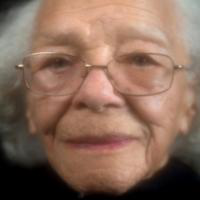

In [ ]:
example['image']

In [ ]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(checkpoint_path)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import(
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
    RandomRotation,
    ColorJitter
)

In [ ]:
normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
            RandomHorizontalFlip(),
            RandomRotation(20),
            ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
# training + validation splitting
splits = dataset['test'].train_test_split(test_size = .1, shuffle = False)
train_ds = splits['train']
test_ds = splits['test']

In [ ]:
# transform train dataset and test dataset
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_test)

In [ ]:
test_ds[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x7F20346E9600>,
 'age': 66,
 'gender': 'male',
 'race': 'white',
 'image_name': '66_0_0_20170109013237361.jpg',
 'pixel_values': tensor([[[ 0.2453,  0.3652,  0.4851,  ..., -0.6109, -0.7650, -0.8507],
          [ 0.2453,  0.3652,  0.4851,  ..., -0.6109, -0.7479, -0.8507],
          [ 0.2453,  0.3652,  0.4851,  ..., -0.5938, -0.7479, -0.8335],
          ...,
          [-0.0458, -0.0458, -0.0458,  ..., -1.1932, -1.1589, -1.1247],
          [-0.0629, -0.0629, -0.0458,  ..., -1.5014, -1.4843, -1.4500],
          [-0.0801, -0.0629, -0.0458,  ..., -1.8097, -1.7925, -1.7583]],
 
         [[-0.2675, -0.1450, -0.0224,  ..., -0.7227, -0.8627, -0.9328],
          [-0.2675, -0.1450, -0.0224,  ..., -0.7052, -0.8452, -0.9328],
          [-0.2675, -0.1450, -0.0224,  ..., -0.7052, -0.8452, -0.9153],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ..., -1.1253, -1.0903, -1.0553],
          [ 0.0476,  0.0476,  0.0651,  ...

## Defining model for evaluation
### For details about training phase, please look at train_folder

In [ ]:
from transformers import ViTModel
vit_model = ViTModel.from_pretrained(checkpoint_path)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTModel: ['decoder.decoder_norm.bias', 'decoder.decoder_layers.7.attention.attention.value.bias', 'decoder.decoder_layers.3.layernorm_after.bias', 'decoder.decoder_embed.bias', 'decoder.decoder_pos_embed', 'decoder.decoder_layers.6.attention.attention.key.bias', 'decoder.decoder_layers.6.attention.attention.query.weight', 'decoder.decoder_layers.1.attention.attention.value.bias', 'decoder.decoder_layers.7.attention.output.dense.bias', 'decoder.decoder_layers.4.attention.attention.key.weight', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.2.layernorm_before.weight', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.5.output.dense.weight', 'decoder.decoder_layers.1.attention.attention.query.bias', 'decoder.decoder_layers.7.layernorm_after.weight', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.4.attention.attention.val

In [ ]:
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [ ]:
# Define task-specific Classifier
class AgeGenderClassifier(nn.Module):
  def __init__(self):
    super(AgeGenderClassifier, self).__init__()
    self.vit = vit_model
    self.gender_bn = nn.BatchNorm1d(768)
    self.gender_classifier =nn.Linear(768,2)
    self.age_bn = nn.BatchNorm1d(768)
    self.age_regressor = nn.Linear(768,1)

  def forward(self, input_ids):
    outputs = self.vit(input_ids)
    pooler_output = outputs.pooler_output
    
    gender_output = self.gender_classifier(self.gender_bn(pooler_output))
    age_output = self.age_regressor(self.age_bn(pooler_output))
    return gender_output, age_output

In [ ]:
age_gender_model = AgeGenderClassifier()

###Data Loader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pixel_values = item['pixel_values']
        gender = 1.0 if item['gender'] == 'female' else 0.0  # encode 'female' as 1.0 and 'male' as 0.0
        age = float(item['age'])
        return pixel_values, torch.tensor(gender), torch.tensor(age)

In [ ]:
train_dataset = CustomDataset(train_ds)
test_dataset = CustomDataset(test_ds)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [ ]:
dataloaders = {'train': train_loader, 'test': test_loader}

In [ ]:
model = age_gender_model
from torch import optim
optimizer = optim.Adam(model.parameters(), lr= 10e-5, weight_decay = 1e-4)

##  Evaluation with experiment 1:

In [ ]:
sample_idx = 555 # Choose the index of the photo to display for 3 experiments

In [ ]:
# Loading trained checkpoints from experiment 1 model:
checkpoint = torch.load('/content/drive/MyDrive/Age and Gender Prediction/model_checkpoints/exp1_checkpoints.pt', map_location=torch.device('cpu'))

In [ ]:
# # Remove the 'module' prefix from the keys in the state dictionary
new_state_dict = {}
for key, value in checkpoint['model_state_dict'].items():
    if key.startswith('module.'):
        new_state_dict[key[7:]] = value
    else:
        new_state_dict[key] = value

# Load the modified state_dict into the model and check for any missing or unexpected keys
load_result = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys: ", load_result.missing_keys)
print("Unexpected keys: ", load_result.unexpected_keys)

# Load the optimizer state_dict without checking missing or unexpected keys
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']


Missing keys:  []
Unexpected keys:  []


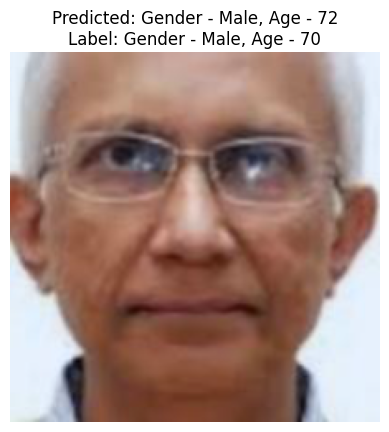

In [ ]:

# Set the model to evaluation mode
model.eval()
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Choose a random photo from the test dataset
sample_data = dataloaders['test'].dataset[sample_idx]
sample_image = sample_data[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
sample_gender_label = int(sample_data[1])  # Convert tensor to integer
sample_age_label = int(sample_data[2])  # Convert tensor to integer

# Make predictions on the sample image
with torch.no_grad():
    sample_gender_pred, sample_age_pred = model(sample_image)

# Convert gender prediction to string label
gender_labels = ['Male', 'Female']
sample_gender_pred_label = gender_labels[sample_gender_pred.argmax()]

# Convert age prediction to integer
sample_age_pred = int(sample_age_pred.item())

# Convert image tensor to NumPy array and transpose the dimensions
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
# Display the photo with predictions and labels
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted: Gender - {sample_gender_pred_label}, Age - {sample_age_pred}\n'
          f'Label: Gender - {gender_labels[sample_gender_label]}, Age - {sample_age_label}')
plt.show()

## Evaluation with experiment 2:



In [ ]:
# Loading trained checkpoints from experiment 2 model:
checkpoint = torch.load('/content/drive/MyDrive/Age and Gender Prediction/model_checkpoints/exp2_checkpoints.pt', map_location=torch.device('cpu'))

In [ ]:
# # Remove the 'module' prefix from the keys in the state dictionary
new_state_dict = {}
for key, value in checkpoint['model_state_dict'].items():
    if key.startswith('module.'):
        new_state_dict[key[7:]] = value
    else:
        new_state_dict[key] = value

# Load the modified state_dict into the model and check for any missing or unexpected keys
load_result = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys: ", load_result.missing_keys)
print("Unexpected keys: ", load_result.unexpected_keys)

# Load the optimizer state_dict without checking missing or unexpected keys
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

Missing keys:  []
Unexpected keys:  []


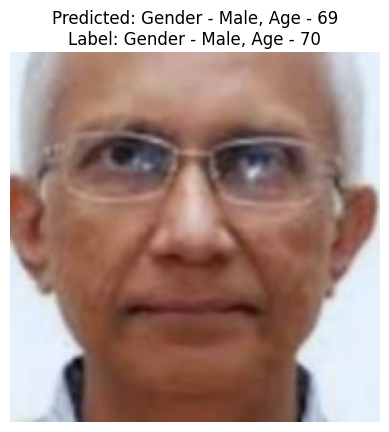

In [ ]:
# Set the model to evaluation mode
model.eval()
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Choose a random photo from the test dataset
sample_data = dataloaders['test'].dataset[sample_idx]
sample_image = sample_data[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
sample_gender_label = int(sample_data[1])  # Convert tensor to integer
sample_age_label = int(sample_data[2])  # Convert tensor to integer

# Make predictions on the sample image
with torch.no_grad():
    sample_gender_pred, sample_age_pred = model(sample_image)

# Convert gender prediction to string label
gender_labels = ['Male', 'Female']
sample_gender_pred_label = gender_labels[sample_gender_pred.argmax()]

# Convert age prediction to integer
sample_age_pred = int(sample_age_pred.item())

# Convert image tensor to NumPy array and transpose the dimensions
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
# Display the photo with predictions and labels
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted: Gender - {sample_gender_pred_label}, Age - {sample_age_pred}\n'
          f'Label: Gender - {gender_labels[sample_gender_label]}, Age - {sample_age_label}')
plt.show()

## Evaluation experiment 3:

In [ ]:
# Loading trained checkpoints from experiment 3 model:
checkpoint = torch.load('/content/drive/MyDrive/Age and Gender Prediction/model_checkpoints/exp3_checkpoints.pt', map_location=torch.device('cpu'))

In [ ]:
# # Remove the 'module' prefix from the keys in the state dictionary
new_state_dict = {}
for key, value in checkpoint['model_state_dict'].items():
    if key.startswith('module.'):
        new_state_dict[key[7:]] = value
    else:
        new_state_dict[key] = value

# Load the modified state_dict into the model and check for any missing or unexpected keys
load_result = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys: ", load_result.missing_keys)
print("Unexpected keys: ", load_result.unexpected_keys)

# Load the optimizer state_dict without checking missing or unexpected keys
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

Missing keys:  []
Unexpected keys:  []


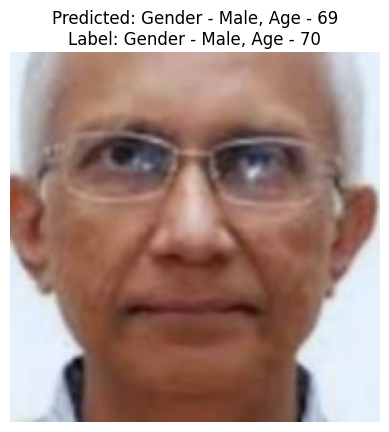

In [ ]:
# Set the model to evaluation mode
model.eval()
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Choose a random photo from the test dataset
sample_data = dataloaders['test'].dataset[sample_idx]
sample_image = sample_data[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
sample_gender_label = int(sample_data[1])  # Convert tensor to integer
sample_age_label = int(sample_data[2])  # Convert tensor to integer

# Make predictions on the sample image
with torch.no_grad():
    sample_gender_pred, sample_age_pred = model(sample_image)

# Convert gender prediction to string label
gender_labels = ['Male', 'Female']
sample_gender_pred_label = gender_labels[sample_gender_pred.argmax()]

# Convert age prediction to integer
sample_age_pred = int(sample_age_pred.item())

# Convert image tensor to NumPy array and transpose the dimensions
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
# Display the photo with predictions and labels
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted: Gender - {sample_gender_pred_label}, Age - {sample_age_pred}\n'
          f'Label: Gender - {gender_labels[sample_gender_label]}, Age - {sample_age_label}')
plt.show()